# Finding heavy traffic indicators on I-94
---

We're going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).
Interstate 94 (I-94) is an east–west Interstate Highway connecting the Great Lakes and northern Great Plains regions of the United States.

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

## 1. Initial exploration. 

We start with rading dataset and checking for contents.

In [2]:
import pandas as pd
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz')
traffic.info()
traffic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


From [dataset documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#) we can find out meaning of each column of our dataset.

Attribute Information:

* `holiday` Categorical US National holidays plus regional holiday, Minnesota State Fair
* `temp` Numeric Average temp in kelvin
* `rain_1h` Numeric Amount in mm of rain that occurred in the hour
* `snow_1h` Numeric Amount in mm of snow that occurred in the hour
* `clouds_all` Numeric Percentage of cloud cover
* `weather_main` Categorical Short textual description of the current weather
* `weather_description` Categorical Longer textual description of the current weather
* `date_time` DateTime Hour of the data collected in local CST time
* `traffic_volume` Numeric Hourly I-94 ATR 301 reported westbound traffic volume

The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

To get a first perception of our data we will plot histogram of `traffic volume` as time series.  

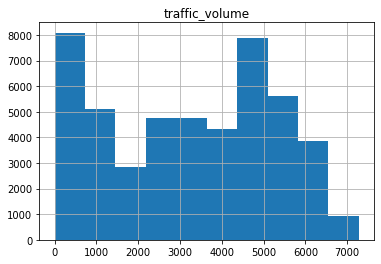

In [3]:
import matplotlib.pyplot as plt
traffic.hist('traffic_volume')
plt.show()

From histogram above we see that there are two picks in span `0-800` and `4300-5100`. Spread of values in not uniform and cant be described unabiguously in words. Let's use built in methods to describe it statisticaly. 

In [4]:
traffic['traffic_volume'].describe()
traffic['traffic_volume'].sum()

157136284

There are 48204 entries, meaning to say that there are 48204 hour spans with recorded data. Mean traffic volume is 3260 cars per hour. Max value of traffic is 7280 and minimum value is 0. There are 25% of values less than 1193, 50% of values less than 3380 and 75% of values less than 4933. First perception is that I-94 is highly congested road with good throughput. About 50% of the time there is traffic rate of 1 car per second. Remarkable!

There is hypothesis that nighttime and daytime might influence traffic volume. Let's dig deeper into data to find more descriptive data. 

## 2. Nighttime/Daytime dependance of `traffic volume`

We'll start by dividing the dataset into two parts:

    Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
    Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

We first convert data in `date_time` column do `Datetime` dtype. And then create two datasets filtered by time of the day.

In [5]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
daytime = traffic[traffic['date_time'].dt.hour.between(7,19)]
nighttime = traffic[traffic['date_time'].dt.hour.between(0,6) | traffic['date_time'].dt.hour.between(20,24)]

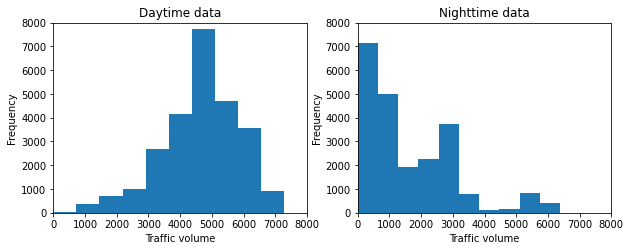

In [6]:
plt.figure(figsize = (10,3.5))

plt.subplot(1,2,1)
plt.hist(daytime['traffic_volume'])
plt.title('Daytime data')
plt.xlim(0, 8000)
plt.ylim(0, 8000)
plt.xlabel('Traffic volume')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(nighttime['traffic_volume'])
plt.title('Nighttime data')
plt.xlim(0, 8000)
plt.ylim(0, 8000)
plt.xlabel('Traffic volume')
plt.ylabel('Frequency')
plt.show()

In [7]:
print(daytime['traffic_volume'].describe())
print(daytime['traffic_volume'].sum())

count    25838.000000
mean      4649.292360
std       1202.321987
min          0.000000
25%       4021.000000
50%       4736.000000
75%       5458.000000
max       7280.000000
Name: traffic_volume, dtype: float64
120128416


**Daytime** histogram shows distinct pattern of normal destribution. Values groups around mean value of `4500-5000` with minimum of `o` and maximum of `7280` cars per hour. Only 25% of data is below `4021`. Total figure of `value_traffic` on daytime is 120128416 cars.

In [8]:
print(nighttime['traffic_volume'].describe())
print(nighttime['traffic_volume'].sum())

count    22366.000000
mean      1654.648484
std       1425.175292
min          0.000000
25%        486.000000
50%       1056.500000
75%       2630.750000
max       6386.000000
Name: traffic_volume, dtype: float64
37007868


**Nighttime** `traffic_volume` histogram doesn't have destinct pattern. There are two peacks in range `0-1000` and `2500-3000`. Min value is `0`, max is `6386` and mean is `1654`. 75% of values are less than `2386`. Total traffic for period of observation during night time is `37007868` - this is 23,6% of total traffic volume for period of observation. 

As nightime traffic is less dense - I suggest to remove this part of data from analysis, since we are focused on *heavy traffic*.

# 3. Time indicators
One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

    Month
    Day of the week
    Time of day

C:\Users\ilias\AppData\Local\Temp\ipykernel_12204\446453578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime['month'] = daytime['date_time'].dt.month


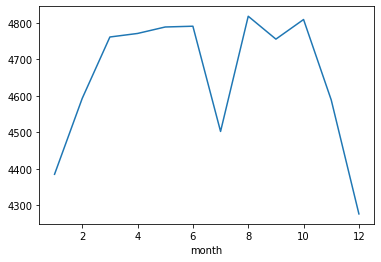

In [9]:
daytime['month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()
by_month['traffic_volume'].plot.line()
plt.show()


Above is `traffic_volume` destribution per month. Line plot is skewed. There are two destinct minimums in *January* and *July*. While *January* minimum can be explained as a hollyday month, there is no good explanation for *July* to be minimum. All the rest monthes from march till october can be decribed as evenly spreaded. Lets have a look on `traffic_value` destribution per year.

C:\Users\ilias\AppData\Local\Temp\ipykernel_12204\3453628961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime['year'] = daytime['date_time'].dt.year


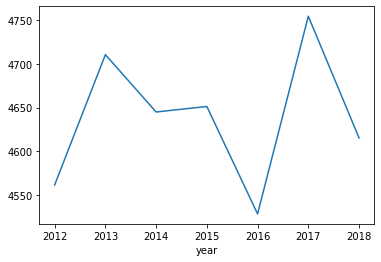

In [10]:
daytime['year'] = daytime['date_time'].dt.year
per_year = daytime.groupby('year').mean()
per_year['traffic_volume'].plot.line()
plt.show()

Weird cardigram we got there. It is strange to such a huge value divercity on such a big time span as year. Minimums in 2012 and 2018 are explainable. Those years have encomolete data, since record starts in October and ends in september. There defenately some explanation for `July`'s minimum. Let's Google on that. 

[Article](https://eu.freep.com/story/news/local/michigan/wayne/2016/06/07/road-construction-on-i94/85554670/) sais that there were major constructions in progress during July 2016. This fact affected the histogram shape.

**Day of the week**

C:\Users\ilias\AppData\Local\Temp\ipykernel_12204\698872498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime['week_day'] = daytime['date_time'].dt.dayofweek


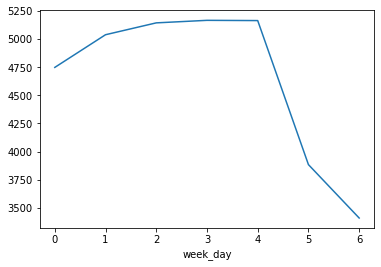

In [11]:
daytime['week_day'] = daytime['date_time'].dt.dayofweek
by_weekday = daytime.groupby('week_day').mean()
by_weekday['traffic_volume'].plot.line()
plt.show()

From line plot above we can see evenly spreaded values from monday to friday and logarithmic discending durind weekends. From the same [article](https://eu.freep.com/story/news/local/michigan/wayne/2016/06/07/road-construction-on-i94/85554670/) we can read out that most of construction works take place during weekends which can also affect destribution. But defenately during working days road is much more congested.

**Time of day**

What we found out earlier - during weekends traffic is less dense. We can skip this info from analysis. We will start from separating weekends data and afterwards will create line plot. 

C:\Users\ilias\AppData\Local\Temp\ipykernel_12204\4273733832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime['hour'] = daytime['date_time'].dt.hour


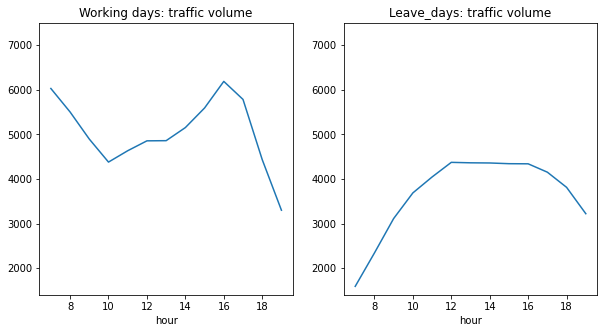

In [12]:
#we will start from adding "hour" column to dataset
daytime['hour'] = daytime['date_time'].dt.hour

#next step - we will split dataset on two as follows:
work_days = daytime.copy()[daytime['week_day'].between(0,4)]
leave_days = daytime.copy()[daytime['week_day'].between(5,6)]

#next step - we will group traffic volume by 'hour' column
w_days = work_days.groupby('hour').mean()
l_days = leave_days.groupby('hour').mean()

#next step - we will create grid chart with leave_days and work_days traffic volume line plots side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
w_days['traffic_volume'].plot.line()
plt.title('Working days: traffic volume')
plt.ylim(1400,7500)

plt.subplot(1,2,2)
l_days['traffic_volume'].plot.line()
plt.title('Leave_days: traffic volume')
plt.ylim(1400,7500)
plt.show()



It is and was obvious that during working days traffic is more dense. Leave days plot pattern shows kind of normal destribution. There is platou from 12 to 16 hours with average value of 4200 cars per hour. 

On the working days the plot is skewed. There are two picks at 7 and 16 hours. This is the time whеn people go to work and back home respectively. There is rapid logorithmic descending from 17 to 19 hundred. Pick values are arond 6000 cars per hour.

**SUMMING UP** our findings we can conclude:
* The highest traffic appears from march to october during working days with pick values at 7 and 16 o'clock.
* Traffic is less dese during weekends and cold monthes of November, desember, january and february. 

It is interesting to find out which weather condition affect the traffic the most. Is traffic less due to less drivers on the road or it is a mater of carring capacity (due to bad road condition).

# 4. Weather indicators

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

A few of these columns are numerical so let's start by looking up their correlation values with traffic_volume.For analysis we will use daytime dataset.

In [13]:
daytime.corr()['traffic_volume']

temp              0.118084
rain_1h           0.004020
snow_1h           0.003768
clouds_all       -0.033410
traffic_volume    1.000000
month            -0.017397
year             -0.000458
week_day         -0.371023
hour             -0.007369
Name: traffic_volume, dtype: float64

There is no strong correlation with any of weather desriptive columns. The highest correlation value of +0,12 appeared on `temp` column. That was expected before, while analizing `traffic_value` destribution by `month`. Let's create a scatter plot.

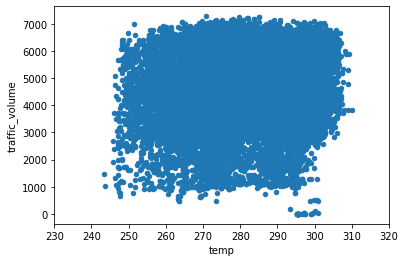

In [14]:
daytime.plot.scatter('temp','traffic_volume')
plt.xlim(230,320)
plt.show()

Thanks to mathematical methods of correlation value calculation. It is not possible to find any pattern from scatterplot above. There is no reliable weather condition state to make judjement about `traffic_volume` dependance. Those were numeric weather indicators. Lets see if categorical ones will give us more information.

Categorical weather-related columns: `weather_main` and `weather_description`.

We're going to calculate the average traffic volume associated with each unique value in these two columns. We've already calculated the values for you — we grouped the data by weather_main and weather_description while using the mean as an aggregate function.

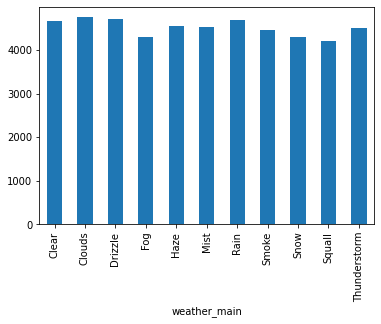

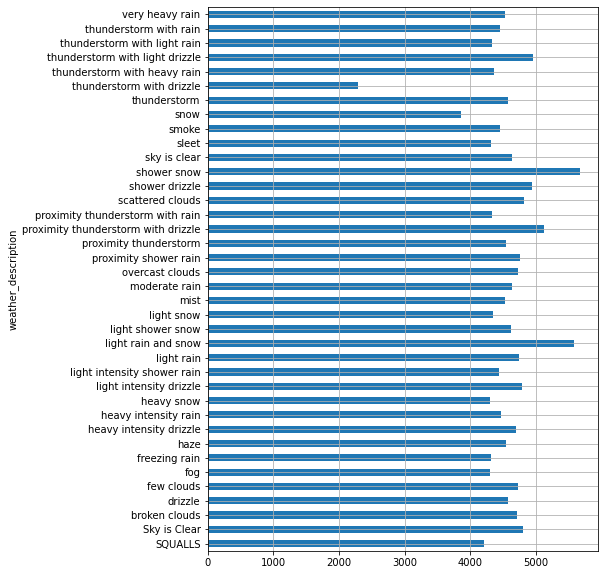

In [16]:
# create new dataset grouped on values of weather descriptive columns
weather_main = daytime.groupby('weather_main').mean()
weather_description = daytime.groupby('weather_description').mean()
# building bar plots for both
weather_main['traffic_volume'].plot.bar()
plt.show()
plt.figure(figsize = (7,10))
weather_description['traffic_volume'].plot.barh()
plt.grid()
plt.show()


From `weather main` bar plot we see that there is no sighnificant changes on `traffic volume`. `Weather description` column has gives broad understanding of factors. On this horisontal bar plot we can see that there are 3 weather indicators with traffic volume more than 5000 cars per hour. That can be considered as heavy volume traffic indicators.

Those indicators are `shower snow`, `proximity thunderstorm with drizzle` and `light rain and snow`. Those weather conditions can be described as bad but not disasterous. Pribably with that weather more people like to get to job on own cars insted of busicle or public transport.

## Conclusion

In this project we analised time and weather indicators of heavy traffic volume on I-94 Interstate road. We found following conditions to be intensifying the traffic volume:

* Time indicators:

    1. Working days of the week
    2. Monthes from march to october
    3. Pick values of traffic on 7 and 16 o'clock

* Weather indicators:

    4. Shower snow
    5. Proximity thunderstorm with drizzle
    6. Light rain and snow
